# Transformer
The goal of this notebook is to create an educational implementation of the transformer with minimal dependencies that's easy to map to the paper.

### References
https://github.com/pytorch/examples/blob/main/word_language_model/

https://github.com/karpathy/nanoGPT/tree/master

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class Embeddings(nn.Module):
    def __init__(self, positions, vocab_size, dmodel):
        super().__init__()
        self.word_embs = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=dmodel
        )
        # TODO when we have a more interesting dataset compare sinusoid vs learnable embeddings
        p_grid, i_grid = torch.meshgrid(
            torch.arange(positions),
            torch.arange(dmodel),
            indexing='ij'
        )
        self.register_buffer('pos_sin', torch.sin(p_grid / (10000**(2 * i_grid / dmodel))))
        self.register_buffer('pos_cos', torch.cos(p_grid / (10000**(2 * i_grid / dmodel))))

    def forward(self, x):
        e = self.word_embs(x)
        e = (e + self.pos_sin + self.pos_cos)
        return e

In [3]:
# Inputs q,k,v are positions x dk, or positions x dv
# Dot all q with k. One must be tranposed to make this line up
class SDPA(nn.Module):
    def __init__(self, causal, positions, dkv):
        super().__init__()
        self.pos = positions
        self.d = dkv
        self.causal = causal
        if causal:
            self.register_buffer('mask', torch.tril(torch.ones(self.pos, self.pos)))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, q, k, v):
        assert(self.d == k.shape[-1])
        q_dot_k = torch.bmm(q, (k.transpose(-2, -1)))
        scaled = q_dot_k / (math.sqrt(self.d))
        if self.causal:
            # TODO is this an elementwise or a matmul?
            # scaled = torch.bmm(scaled, self.mask.expand(q.shape[0], self.pos, self.pos)) 
            scaled = scaled * self.mask
        logits = self.softmax(scaled)
        out = torch.bmm(logits, v)
        return out


In [4]:
class Head(nn.Module):
    def __init__(self, causal, positions, dkv, dmodel):
        super().__init__()
        self.v_projection = nn.Linear(dmodel, dkv)
        self.k_projection = nn.Linear(dmodel, dkv)
        self.q_projection = nn.Linear(dmodel, dkv)

        self.sdpa = SDPA(causal, positions, dkv)

    def forward(self, v, k, q):
        vp = self.v_projection(v)
        kp = self.k_projection(k)
        qp = self.q_projection(q)
        return self.sdpa(qp, kp, vp)

# dk = dv = dmodel/nhead
# wq is dmodel x dk
# wk is dmodel x dk
# wv is dmodel x dv
class MHA(nn.Module):
    def __init__(self, causal, positions, nhead, dmodel):
        super().__init__()
        assert(dmodel % nhead == 0)
        self.heads = nn.ModuleList([Head(causal, positions, dmodel//nhead, dmodel) for _ in range(nhead)])
        
        # TODO In the paper it's called WO, and hd_v x dmodel, but b/c d_v = dmodel/h it turns out to be square.
        self.out_projection = nn.Linear(dmodel, dmodel)

    def forward(self, v, k, q):
        head_outputs = [h(v, k, q) for h in self.heads]
        catd = torch.cat(head_outputs, dim=-1)
        
        projection = self.out_projection(catd)
        return projection

In [5]:
class FeedForward(nn.Module):
    def __init__(self, dmodel, ff, dropout=0.1):
        super().__init__()
        self.f0 = nn.Linear(dmodel, ff)
        self.f1 = nn.Linear(ff, dmodel)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.f0(x)
        x = self.act(x)
        x = self.f1(x)
        x = self.dropout(x)
        return x

# Input/Output are Batch, Positions, then Model Dimension.
class TransformerDecoder(nn.Module):
    def __init__(self, positions, dmodel, ff, nhead, dropout=0.1):
        super().__init__()
        self.mha0 = MHA(True, positions, nhead, dmodel)
        self.layernorm0 = nn.LayerNorm(dmodel)
        self.mha1 = MHA(True, positions, nhead, dmodel)
        self.layernorm1 = nn.LayerNorm(dmodel)
        self.feedforward = FeedForward(dmodel, ff, dropout)
        self.layernorm2 = nn.LayerNorm(dmodel)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, inputs, cross=None): 
        x = self.mha0(inputs, inputs, inputs)
        x = self.layernorm0(x + inputs)

        x_pre_mha1 = x
        if cross is not None:
            x = self.mha1(cross, cross, x)
        else:
            x = self.mha1(x, x, x)
        x = self.layernorm1(x + x_pre_mha1)

        x_pre_ff = x
        x = self.feedforward(x)
        x = self.layernorm2(x + x_pre_ff)
        return x

In [6]:
class OutputProjection(nn.Module):
    def __init__(self, dmodel, vocab_size):
        super().__init__()
        self.proj = nn.Linear(dmodel, vocab_size)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.proj(x)

        # You'd expect a softmax here, but we're leaving it out and going to let CrossEntropyLoss handle it instead.
        return x

In [7]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, positions, dmodel, ff, nhead, nlayers, dropout=0.1):
        super().__init__()
        self.emb = Embeddings(positions, vocab_size, dmodel)
        self.transformer_layers = nn.ModuleList([TransformerDecoder(positions, dmodel, ff, nhead=nhead, dropout=dropout) for _ in range(nlayers)])
        self.out = OutputProjection(dmodel, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        for layer in self.transformer_layers:
            x = layer(x)

        x = self.out(x)
        return x

In [8]:
# From https://github.com/karpathy/minGPT/blob/master/demo.ipynb
# Contrived dataset to show that our transformer kind of works.

from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import pickle

class SortDataset(Dataset):
    """ 
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: I I I I I 0 0 0 1 1 2
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=6, num_digits=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.num_digits = num_digits
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.num_digits
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):
        
        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that 
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1
        return x, y


In [9]:
batchsize = 256
length = 6
num_digits = 5
dset_train = SortDataset(split='train', length=length, num_digits=num_digits)
dset_test = SortDataset(split='test', length=length, num_digits=num_digits)
train_loader = DataLoader(dset_train, batch_size=batchsize, num_workers=4, shuffle=True)
test_loader = DataLoader(dset_test, batch_size=batchsize, num_workers=4, shuffle=True)

In [10]:
dmodel = 64
positions = dset_train.get_block_size()
vocab_size = dset_train.get_vocab_size()
ff = 4 * dmodel
heads_per_layer = 4
layers = 4

model = Transformer(vocab_size, positions, dmodel, ff, heads_per_layer, layers, 0.1).to(device)

Epoch 0, Current loss is 1.595977783203125
Epoch 1, Current loss is 1.2449209690093994
Epoch 2, Current loss is 1.011880874633789
Epoch 3, Current loss is 0.8803423643112183
Epoch 4, Current loss is 0.8338440656661987
Epoch 5, Current loss is 0.8183137774467468
Epoch 6, Current loss is 0.8087917566299438
Epoch 7, Current loss is 0.7970739006996155
Epoch 8, Current loss is 0.8036062121391296
Epoch 9, Current loss is 0.8004189729690552


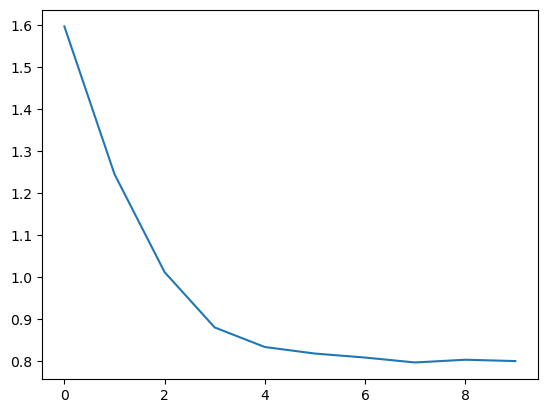

In [11]:
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

lossfn = nn.CrossEntropyLoss()

loss_plot = []
for epoch in range(epochs):
    model.train()
    for i, (text, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # We take the last "length" digits so that the network is trained to replicate these from the input.
        # It's not really necessary, it work also work to only calculate loss from the last digit, which is the actual prediction.
        targets = F.one_hot(target[..., -length:], num_classes=num_digits).to(device, dtype=torch.float32)
        outs = model(text.to(device))
        loss = lossfn(outs[..., -length:, :], targets)
        loss.backward()
        optimizer.step()

    losses = []
    model.eval()
    for i, (text, target) in enumerate(test_loader):
        with torch.no_grad():
            targets = F.one_hot(target[..., -length:], num_classes=num_digits).to(device, dtype=torch.float32)
            outs = model(text.to(device))
            loss = lossfn(outs[..., -length:, :], targets)
            losses.append(loss)

    epoch_loss = torch.Tensor(losses).mean().item()
    print("Epoch {}, Current loss is {}".format(epoch, epoch_loss))
    loss_plot.append(epoch_loss)

import matplotlib.pyplot as plt
plt.plot(loss_plot)

In [12]:
model.eval()
with torch.no_grad():
    a = torch.tensor([[0, 1, 3, 4, 3, 2,    0, 1, 2, 3, 3]]) # Next digit is 4
    out = model(a.to(device))
    z = F.softmax(out[0, -length:, :], dim=-1)
    print("Probs {}\nSorted {}\n".format(z.cpu(), torch.argmax(z, dim=-1).cpu()))

    a = torch.tensor([[0, 1, 2, 2, 1, 2,    0, 1, 1, 2, 2]]) # Next digit is 2
    out = model(a.to(device))
    z = F.softmax(out[0, -length:, :], dim=-1)
    print("Probs {}\nSorted {}\n".format(z.cpu(), torch.argmax(z, dim=-1).cpu()))
    

Probs tensor([[9.8231e-01, 8.7392e-03, 2.4967e-03, 2.0364e-03, 4.4176e-03],
        [1.9079e-03, 9.9072e-01, 4.4311e-03, 1.9536e-03, 9.8262e-04],
        [3.3022e-03, 4.4532e-03, 9.7871e-01, 1.2126e-02, 1.4043e-03],
        [3.3568e-03, 1.9370e-03, 2.9684e-03, 9.8899e-01, 2.7436e-03],
        [2.7855e-03, 2.2410e-03, 1.9254e-03, 9.8899e-01, 4.0589e-03],
        [2.9284e-03, 8.9401e-04, 1.1977e-03, 3.9823e-03, 9.9100e-01]])
Sorted tensor([0, 1, 2, 3, 3, 4])

Probs tensor([[0.9793, 0.0109, 0.0016, 0.0034, 0.0047],
        [0.0050, 0.9858, 0.0013, 0.0045, 0.0034],
        [0.0021, 0.9885, 0.0049, 0.0020, 0.0026],
        [0.0023, 0.0034, 0.9842, 0.0039, 0.0062],
        [0.0023, 0.0034, 0.9824, 0.0054, 0.0066],
        [0.0029, 0.0021, 0.9270, 0.0506, 0.0174]])
Sorted tensor([0, 1, 1, 2, 2, 2])

